In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import re
import copy

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN


In [3]:
bcldirs=['180515_SL-HXR_0665_AFCHH2H3CCXY','180515_SL-HXS_0555_AFCHGYTGCCXY',
        '180515_SL-HXR_0666_BFCHGY7FCCXY','180515_SL-HXS_0556_BFCHH2FNCCXY']

for channel in range(32):
    print(channel)
    channelname=str(channel+1)
    for bcldir in bcldirs:
        gbc_cbc_file='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/data/count_barcodes/mismatches2/'+bcldir+'/A549_'+re.sub(PROTEIN,'p53',PROTEIN)+'_'+channelname+'.'+bcldir+'.variantBarcodeCounts.gz.with_cellbc_and_UMI.gz'
        cur_data=pd.read_csv(gbc_cbc_file,compression='gzip',sep='\t',header=None)
        cur_data.columns=['gbc','r2','pos','strand','cbc','umi','alignments','read_name']
        cur_data['cbc']=cur_data['cbc']+'ch'+str(channel)
        if channel==0:
            gbc_data=cur_data
        else:
            gbc_data=pd.concat([gbc_data,cur_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [4]:
import copy
gbc_data_original=copy.deepcopy(gbc_data)
gbc_data_original=gbc_data_original.drop_duplicates()
gbc_data_original.shape

(1492103, 8)

In [5]:
#keep only vbcs that map to - strand for vbcs, and to + strand for puro res
keep=[]
strand=list(gbc_data_original['strand'])
gbc=list(gbc_data_original['gbc'])
for i in range(gbc_data_original.shape[0]):
    cur_strand=strand[i]
    cur_gbc=gbc[i]
    if cur_strand=='-' and gbc!='Puro_res':
        keep.append(i)
    else:
        if cur_strand=='+' and gbc=='Puro_res':
            keep.append(i)
print('keep',len(keep),'total',gbc_data_original.shape[0])

gbc_data_filtered=copy.deepcopy(gbc_data_original)
gbc_data_filtered=gbc_data_filtered.iloc[keep,:]

keep 1131670 total 1492103


In [6]:
import perturbseq as perturb
gbc_data=perturb.pp.compute_TPT(gbc_data_filtered)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


In [7]:
print(gbc_data.shape)
print(gbc_data.head())

(1009370, 6)
          gbc                   cbc         umi  cbc-umi-r2-count  \
0  TP53_G266R  AAAAATGTCGCTAGCGch22  GATCGATCAT                 1   
1  TP53_R282W  AAAACAAGTTGGTTTGch17  TAGGTGTAGC                 1   
2  TP53_M246V  AAAACTGGTGGGTATGch17  TAGTCGGCGC                 1   
3  TP53_C275Y  AAAAGATGGTCACCTAch14  AAATTTAGTA                 1   
4  TP53_C275Y   AAAAGCAAAGCGGCTTch6  CTTGTCCACC                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  


In [8]:
gbc_data_filtered.loc[:,['cbc','umi','r2']].drop_duplicates().shape

(1009370, 3)

In [9]:
#now, compute lenient TPT that only looks at whether reads mapped to the same gbc, 
#even if they have diff sequences

gbc_data_filtered_lenient=copy.deepcopy(gbc_data_filtered)
gbc_data_filtered_lenient['r2']=gbc_data_filtered_lenient['gbc']
gbc_data=perturb.pp.compute_TPT(gbc_data_filtered_lenient)

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20)
plt.xlim(0,1)
plt.show()

print(gbc_data['TPT'].describe())

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result
count    852458.000000
mean          0.999978
std           0.003451
min           0.200000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: TPT, dtype: float64


In [10]:
#quickly look at the reads with bad TPTs
#there are v few of them (yay!)

gbc_data.loc[gbc_data['TPT']<1,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
29031,Puro_res,AAGCAGTGGTATCAACch12,GCAGAGTACA,2,3,0.666667
29032,TP53_p.Glu339Lys,AAGCAGTGGTATCAACch12,GCAGAGTACA,1,3,0.333333
188527,TP53_R273L,ATTTCTGGTTCCTCCAch28,TCCACCCTCA,1,2,0.500000
188528,TP53_V272L,ATTTCTGGTTCCTCCAch28,TCCACCCTCA,1,2,0.500000
205649,TP53_E286K,CACACCTAGCTGATAAch22,TAAGGTGAGT,1,2,0.500000


In [11]:
TPT_threshold=1.0

counts_with_tpt=gbc_data
print(counts_with_tpt.head())

keep=list([x>=TPT_threshold for x in counts_with_tpt['TPT']])
filtered=counts_with_tpt[keep]
print(filtered.shape)
print(filtered.head())

          gbc                   cbc         umi  cbc-umi-r2-count  \
0  TP53_G266R  AAAAATGTCGCTAGCGch22  GATCGATCAT                 1   
1  TP53_R282W  AAAACAAGTTGGTTTGch17  TAGGTGTAGC                 1   
2  TP53_M246V  AAAACTGGTGGGTATGch17  TAGTCGGCGC                 1   
3  TP53_C275Y  AAAAGATGGTCACCTAch14  AAATTTAGTA                 1   
4  TP53_C275Y   AAAAGCAAAGCGGCTTch6  CTTGTCCACC                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  
(852420, 6)
          gbc                   cbc         umi  cbc-umi-r2-count  \
0  TP53_G266R  AAAAATGTCGCTAGCGch22  GATCGATCAT                 1   
1  TP53_R282W  AAAACAAGTTGGTTTGch17  TAGGTGTAGC                 1   
2  TP53_M246V  AAAACTGGTGGGTATGch17  TAGTCGGCGC                 1   
3  TP53_C275Y  AAAAGATGGTCACCTAch14  AAATTTAGTA                 1   
4  TP53_C275Y   AAAAGCAAAGCGGCTTch6  CTTGTCCACC                 1   

   cbc-umi-cou

In [12]:
outpath=results_prefix+'.anno'
print(outpath)

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/processed_data/A549.TP53.anno


In [13]:
filtered_counts=filtered.groupby(['cbc','gbc','umi']).sum()
print(filtered_counts.shape)
filtered_counts.head()

filtered_counts.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')

filtered_counts=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')
print(filtered_counts.shape)
filtered_counts.head()

#go through each line, make 2 matrices
#one gives us the total reads per cbc-gbc, one gives us the umis.

umi_counts={}
read_counts={}
for i in range(filtered_counts.shape[0]):
    if i%100000==0:
        print(i)
    cbc=filtered_counts.loc[i,'cbc']
    gbc=filtered_counts.loc[i,'gbc']
    umi=filtered_counts.loc[i,'umi']
    count=filtered_counts.loc[i,'cbc-umi-count']
    if cbc not in umi_counts:
        umi_counts[cbc]={}
        read_counts[cbc]={}
    if gbc not in umi_counts[cbc]:
        umi_counts[cbc][gbc]=set()
        read_counts[cbc][gbc]=0
    umi_counts[cbc][gbc].add(umi)
    read_counts[cbc][gbc]+=count
    
cbcs=list(set(filtered_counts['cbc']))
gbcs=list(set(filtered_counts['gbc']))
m_reads=np.zeros((len(cbcs),len(gbcs)))
m_umis=np.zeros((len(cbcs),len(gbcs)))
for cbc_idx in range(len(cbcs)):
    if cbc_idx%10000==0:
        print(cbc_idx)
    cbc=cbcs[cbc_idx]
    for gbc_idx in range(len(gbcs)):
        gbc=gbcs[gbc_idx]
        if cbc in umi_counts:
            if gbc in umi_counts[cbc]:
                count=len(list(umi_counts[cbc][gbc]))
                m_umis[cbc_idx,gbc_idx]=count
                m_reads[cbc_idx,gbc_idx]=read_counts[cbc][gbc]

(852420, 3)
(852420, 6)
0
100000
200000
300000
400000
500000
600000
700000
800000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000


In [14]:
m_umis_df=pd.DataFrame(m_umis)
m_umis_df.index=cbcs
m_umis_df.columns=gbcs

m_reads_df=pd.DataFrame(m_reads)
m_reads_df.index=cbcs
m_reads_df.columns=gbcs

m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip')
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip')

In [15]:
m_reads_df.head()

,TP53_p.Vl216Vl,TP53_p.Pro301Pro,TP53_p.Gln5Ar,TP53_p.Tyr107His,TP53_p.Al83Vl,TP53_R248L,TP53_H214R,TP53_P152L,TP53_V173L,TP53_p.Ar158Ar,...,TP53_R273L,TP53_R249S,TP53_R248W,TP53_C135F,TP53_R280K,TP53_K132N,TP53_G154V,TP53_S127F,TP53_Y220C,TP53_C275F
ACGATGTGTCAACTGTch3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTGGACTCGAGGTAGch15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTCATTTCAATGTAAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACATGGTTCGCTTAGAch5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
AGATCTGTCGCCTGAGch21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#map the variant names to nice standardized variant names
variants=m_reads_df.columns
print(variants)

Index(['TP53_p.Vl216Vl', 'TP53_p.Pro301Pro', 'TP53_p.Gln5Ar',
       'TP53_p.Tyr107His', 'TP53_p.Al83Vl', 'TP53_R248L', 'TP53_H214R',
       'TP53_P152L', 'TP53_V173L', 'TP53_p.Ar158Ar',
       ...
       'TP53_R273L', 'TP53_R249S', 'TP53_R248W', 'TP53_C135F', 'TP53_R280K',
       'TP53_K132N', 'TP53_G154V', 'TP53_S127F', 'TP53_Y220C', 'TP53_C275F'],
      dtype='object', length=101)


In [17]:
import re
variants_newnames=[]
positions=[]

for i in range(len(variants)):
    
    cur_name=re.sub('TP53_','',variants[i])
    if cur_name=='Puro_res':
        variants_newnames.append('Puro_res')
        continue
    cur_name=re.sub('Glu','E',cur_name)
    cur_name=re.sub('Lys','K',cur_name)
    cur_name=re.sub('Vl','V',cur_name)
    cur_name=re.sub('Pro','P',cur_name)
    cur_name=re.sub('Ar','R',cur_name)
    cur_name=re.sub('Thr','T',cur_name)
    cur_name=re.sub('Ser','S',cur_name)
    cur_name=re.sub('Leu','L',cur_name)
    cur_name=re.sub('Tyr','Y',cur_name)
    cur_name=re.sub('His','H',cur_name)
    cur_name=re.sub('Asp','D',cur_name)
    cur_name=re.sub('Al','A',cur_name)
    cur_name=re.sub('Gly','G',cur_name)
    cur_name=re.sub('Gln','Q',cur_name)
    cur_name=re.sub('Ile','I',cur_name) 
    cur_name=re.sub('As','N',cur_name)
    cur_name=re.sub('p[.]','',cur_name)  
    
    if cur_name=='WT':
        position=0
    else:
        position=int(re.sub(r"\D", "", cur_name))
    positions.append(position)
    
    variants_newnames.append(cur_name)

In [18]:
print(len(variants))

101


In [19]:
m_umis_df=m_umis_df.loc[:,m_reads_df.columns]

In [20]:
m_reads_df.columns=variants_newnames
m_umis_df.columns=variants_newnames

In [21]:
m_umis_df.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R273L,R249S,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F
ACGATGTGTCAACTGTch3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTGGACTCGAGGTAGch15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTCATTTCAATGTAAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACATGGTTCGCTTAGAch5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AGATCTGTCGCCTGAGch21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
list(m_umis_df.columns)

['V216V',
 'P301P',
 'Q5R',
 'Y107H',
 'A83V',
 'R248L',
 'H214R',
 'P152L',
 'V173L',
 'R158R',
 'H193R',
 'P278L',
 'E285K',
 'S366A',
 'V157F',
 'S241C',
 'V272L',
 'A159P',
 'T170T',
 'C176Y',
 'T118T',
 'Y234C',
 'P47S',
 'G245C',
 'KRAS_K5E',
 'M246V',
 'C275Y',
 'I195T',
 'E339K',
 'G105C',
 'P151S',
 'E286K',
 'H179Y',
 'R175H',
 'R249M',
 'R213Q',
 'V31I',
 'S241F',
 'L344L',
 'C277F',
 'P47P',
 'M237I',
 'L194R',
 'G266V',
 'K132R',
 'G244C',
 'T312S',
 'C135Y',
 'G360V',
 'D21D',
 'R273C',
 'G245D',
 'P222P',
 'H179R',
 'G245S',
 'V173M',
 'A159V',
 'H193L',
 'G245V',
 'Y163C',
 'R337L',
 'E2E',
 'R110L',
 'V216M',
 'P295P',
 'C141Y',
 'C238F',
 'G266E',
 'V272M',
 'P36P',
 'Puro_res',
 'R158L',
 'WT',
 'R337C',
 'R273H',
 'C176F',
 'C242F',
 'Y236C',
 'P359P',
 'P250L',
 'R158H',
 'R282W',
 'P278S',
 'E271K',
 'C238Y',
 'R280T',
 'G266R',
 'P153P',
 'H193Y',
 'Y205C',
 'P58R',
 'R273L',
 'R249S',
 'R248W',
 'C135F',
 'R280K',
 'K132N',
 'G154V',
 'S127F',
 'Y220C',
 'C275F'

In [23]:
m_umis_df=m_umis_df.drop(columns=['Puro_res','KRAS_K5E'])

In [24]:
m_reads_df=m_reads_df.drop(columns=['Puro_res','KRAS_K5E'])

In [25]:
new_cells=[]
idx=list(m_umis_df.index)
for i in range(m_umis_df.shape[0]):
    new_cells.append('TP53.'+idx[i])
m_umis_df['cell']=new_cells
m_reads_df['cell']=new_cells

In [26]:
m_umis_df.head()

,V216V,P301P,Q5R,Y107H,A83V,R248L,H214R,P152L,V173L,R158R,...,R249S,R248W,C135F,R280K,K132N,G154V,S127F,Y220C,C275F,cell
ACGATGTGTCAACTGTch3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53.ACGATGTGTCAACTGTch3
ATTGGACTCGAGGTAGch15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53.ATTGGACTCGAGGTAGch15
GTCATTTCAATGTAAGch31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53.GTCATTTCAATGTAAGch31
ACATGGTTCGCTTAGAch5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TP53.ACATGGTTCGCTTAGAch5
AGATCTGTCGCCTGAGch21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TP53.AGATCTGTCGCCTGAGch21


In [27]:
m_umis_df['cell']=list(m_umis_df.index)
m_reads_df['cell']=list(m_reads_df.index)

In [28]:
m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.mut_std.gz',index=False)
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.mut_std.gz',index=False)

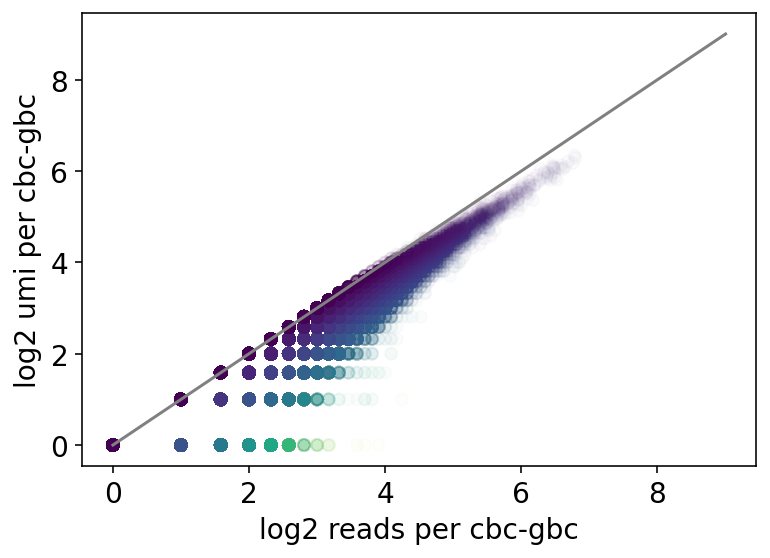

In [29]:
%matplotlib inline
plt.scatter(np.log2(m_reads.flatten()[m_reads.flatten()>0.0]),
            np.log2(m_umis.flatten()[m_umis.flatten()>0.0]),alpha=0.02,
            c=np.log2(m_reads.flatten()[m_reads.flatten()>0.0])-np.log2(m_umis.flatten()[m_umis.flatten()>0.0]))
plt.xlabel('log2 reads per cbc-gbc')
plt.ylabel('log2 umi per cbc-gbc')
plt.plot(np.arange(0, 10), np.arange(0, 10),color='gray')
plt.grid(False)
plt.show()